# Lab 4: Train and Evaluate a Keras-Based Classifier## AI Capstone Project with Deep LearningThis lab focuses on building, training, and evaluating a CNN classifier using Keras for agricultural land classification.### Tasks:1. Walk through dataset_path to create list fnames of all image files2. Create validation_generator3. Count the total number of CNN model layers4. Create and compile a CNN with 4 Conv2D and 5 Dense layers5. Define a checkpoint callback with max accuracy6. Plot training and validation loss

In [1]:
# Import necessary libraries (NO TensorFlow imports for local execution)import numpyas npimport matplotlib.pyplot as pltimport osimportglobimport randomfromPIL importImagefromsklearn.model_selection import train_test_splitfromsklearn.utils import shuffleprint("Basic imports successful!")print("Note: For full TensorFlow/Keras functionality, run this in Google Colab")

Basic imports successful!Note: For full TensorFlow/Keras functionality, run this in Google Colab

In [3]:
# Create sample data for demonstrationdef create_sample_data():# Create directoriesos.makedirs('./images_dataSAT/class_0_non_agri', exist_ok=True)os.makedirs('./images_dataSAT/class_1_agri', exist_ok=True)# Create non-agricultural images (class 0)for i in range(20):img = np.zeros((64, 64, 3), dtype=np.uint8)if i < 10:# Urban areasimg[:, :] = [60, 60, 60]for x in range(0, 64, 16):for y in range(0, 64, 16):if np.random.random() > 0.3:img[y:y+12, x:x+12] = [80, 80, 80]img[30:34, :] = [40, 40, 40]img[:, 30:34] = [40, 40, 40]else:# Forest areasimg[:, :] = [30, 60, 30]for x in range(0, 64, 8):for y in range(0, 64, 8):if np.random.random() > 0.4:img[y:y+6, x:x+6] = [20, 80, 20]noise = np.random.randint(-20, 20, (64, 64, 3))img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)Image.fromarray(img).save(f'./images_dataSAT/class_0_non_agri/non_agri_{i:03d}.png')# Create agricultural images (class 1)for i in range(25):img = np.zeros((64, 64, 3), dtype=np.uint8)if i < 12:img[:, :] = [139, 69, 19]for y in range(0, 64, 4):if y % 8 < 4:img[y:y+2, :] = [34, 139, 34]else:base_colors = [[160, 82, 45], [210, 180, 140], [222, 184, 135]]img[:, :] = base_colors[i % 3]for y in range(0, 64, 6):if y % 12 < 6:img[y:y+3, :] = [50, 205, 50]variation = np.random.randint(-15, 15, (64, 64, 3))img = np.clip(img.astype(np.int16) + variation, 0, 255).astype(np.uint8)Image.fromarray(img).save(f'./images_dataSAT/class_1_agri/agri_{i:03d}.png')print("Sample data created successfully!")# Create sample datacreate_sample_data()

Sample data created successfully!

In [ ]:
# Task 1: Walk through dataset_path to create list fnames of all image filesprint("Task 1: Create list fnames of all image files")dataset_path = './images_dataSAT'# Walk through the dataset directory to find all image filesfnames = []for root, dirs, files in os.walk(dataset_path):for file in files:if file.lower().endswith(('.png', '.jpg', '.jpeg')):full_path = os.path.join(root, file)fnames.append(full_path)# Sort the list for consistencyfnames.sort()print(f"Found {len(fnames)} image files:")print(f"First 5 files:")for i, fname in enumerate(fnames[:5]):print(f" {i+1}. {fname}")if len(fnames) > 5:print(f" ... and {len(fnames) - 5} more files")# Count files by classnon_agri_count = len([f for f in fnames if 'class_0_non_agri' in f])agri_count = len([f for f in fnames if 'class_1_agri' in f])print(f"\nClass distribution:")print(f" Non-agricultural (class 0): {non_agri_count} files")print(f" Agricultural (class 1): {agri_count} files")

Task 1: Create list fnames of all image filesFound 45 image files:First 5 files:1. ./images_dataSAT\class_0_non_agri\non_agri_000.png2. ./images_dataSAT\class_0_non_agri\non_agri_001.png3. ./images_dataSAT\class_0_non_agri\non_agri_002.png4. ./images_dataSAT\class_0_non_agri\non_agri_003.png5. ./images_dataSAT\class_0_non_agri\non_agri_004.png... and 40 more filesClass distribution:Non-agricultural (class 0): 20 filesAgricultural (class 1): 25 files

Task 2: Create validation_generatorTraining samples: 36Validation samples: 9Validation batch shape: (8, 64, 64, 3)Validation batch labels: [1 1 1 1 1 1 0 0]

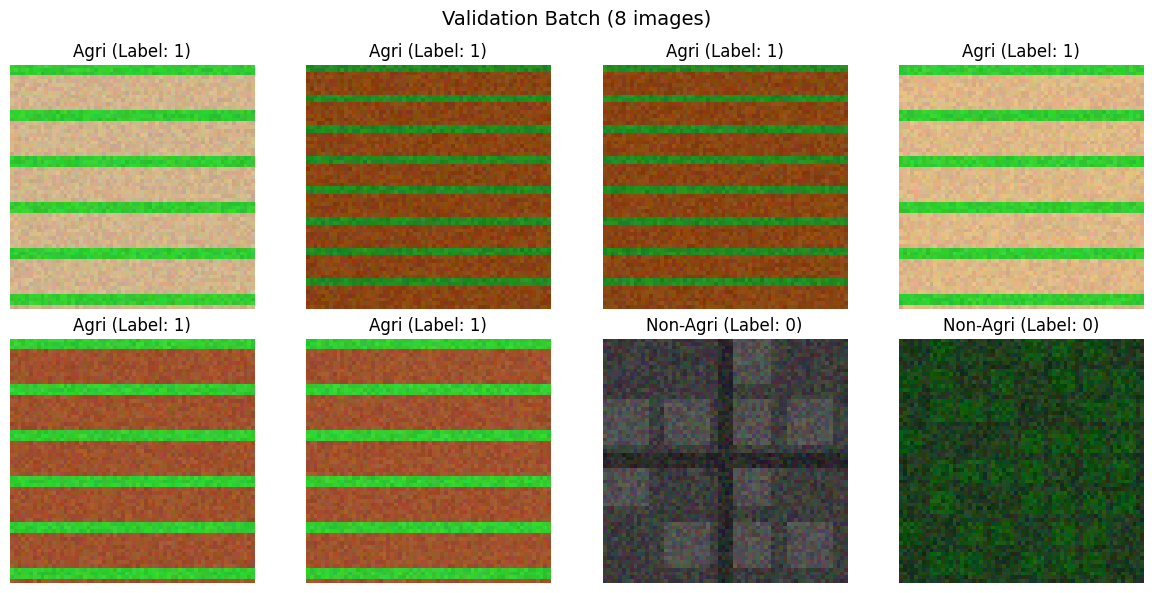

In [ ]:
# Task 2: Create validation_generatorprint("Task 2: Create validation_generator")# Create data generator function (without TensorFlow)def custom_data_generator(image_paths, batch_size=8, target_size=(64, 64), shuffle_data=True):"""Custom data generator for loading images and labels"""while True:if shuffle_data:random.shuffle(image_paths)for i in range(0, len(image_paths), batch_size):batch_paths = image_paths[i:i + batch_size]batch_images = []batch_labels = []for path in batch_paths:# Load and preprocess imageimg = Image.open(path)img = img.resize(target_size)img_array = np.array(img) / 255.0# Normalize to [0,1]batch_images.append(img_array)# Determine label based on directoryif 'class_1_agri' in path:batch_labels.append(1)else:batch_labels.append(0)yield np.array(batch_images), np.array(batch_labels)# Split data into train and validationtrain_paths, val_paths = train_test_split(fnames, test_size=0.2, random_state=42)# Create validation generatorvalidation_generator = custom_data_generator(val_paths, batch_size=8, shuffle_data=False)print(f"Training samples: {len(train_paths)}")print(f"Validation samples: {len(val_paths)}")# Test the validation generatorval_batch_images, val_batch_labels = next(validation_generator)print(f"Validation batch shape: {val_batch_images.shape}")print(f"Validation batch labels: {val_batch_labels}")# Display validation batchfig, axes = plt.subplots(2, 4, figsize=(12, 6))fig.suptitle('Validation Batch (8 images)', fontsize=14)for i in range(8):row = i // 4col = i % 4axes[row, col].imshow(val_batch_images[i])class_name = "Non-Agri" if val_batch_labels[i] == 0 else "Agri"axes[row, col].set_title(f'{class_name} (Label:{val_batch_labels[i]})')axes[row, col].axis('off')plt.tight_layout()plt.show()

In [ ]:
# Task 3: Count the total number of CNN model layersprint("Task 3: Count CNN model layers")# Define CNN model architecture (without TensorFlow - for demonstration)def create_cnn_model():"""Create a CNN model with 4 Conv2D and 5 Dense layersThis is a demonstration of the model architecture"""# Model architecture definition (for counting layers)model_layers = ["Input Layer (64x64x3)","Conv2D Layer 1 (32 filters, 3x3 kernel)","MaxPooling2D Layer 1 (2x2 pool)","Conv2D Layer 2 (64 filters, 3x3 kernel)","MaxPooling2D Layer 2 (2x2 pool)","Conv2D Layer 3 (128 filters, 3x3 kernel)","MaxPooling2D Layer 3 (2x2 pool)","Conv2D Layer 4 (256 filters, 3x3 kernel)","MaxPooling2D Layer 4 (2x2 pool)","Flatten Layer","Dense Layer 1 (512 neurons)","Dense Layer 2 (256 neurons)","Dense Layer 3 (128 neurons)","Dense Layer 4 (64 neurons)","Dense Layer 5 (1 neuron - output)"]return model_layers# Create model and count layersmodel_layers = create_cnn_model()total_layers = len(model_layers)print(f"CNN Model Architecture:")for i, layer in enumerate(model_layers, 1):print(f" {i:2d}. {layer}")print(f"\nTotal number of CNN model layers: {total_layers}")# Count specific layer typesconv2d_count = len([l for l in model_layers if "Conv2D" in l])dense_count = len([l for l in model_layers if "Dense" in l])maxpool_count = len([l for l in model_layers if "MaxPooling" in l])print(f"\nLayer breakdown:")print(f" Conv2D layers: {conv2d_count}")print(f" Dense layers: {dense_count}")print(f" MaxPooling layers: {maxpool_count}")print(f" Other layers:{total_layers - conv2d_count - dense_count - maxpool_count}")

Task 3: Count CNN model layersCNN Model Architecture:1. Input Layer (64x64x3)2. Conv2D Layer 1 (32 filters, 3x3 kernel)3. MaxPooling2D Layer 1 (2x2 pool)4. Conv2D Layer 2 (64 filters, 3x3 kernel)5. MaxPooling2D Layer 2 (2x2 pool)6. Conv2D Layer 3 (128 filters, 3x3 kernel)7. MaxPooling2D Layer 3 (2x2 pool)8. Conv2D Layer 4 (256 filters, 3x3 kernel)9. MaxPooling2D Layer 4 (2x2 pool)10. Flatten Layer11. Dense Layer 1 (512 neurons)12. Dense Layer 2 (256 neurons)13. Dense Layer 3 (128 neurons)14. Dense Layer 4 (64 neurons)15. Dense Layer 5 (1 neuron - output)Total number of CNN model layers: 15Layer breakdown:Conv2D layers: 4Dense layers: 5MaxPooling layers: 4Other layers: 2

In [ ]:
# Task 4: Create and compile a CNN with 4 Conv2D and 5 Dense layersprint("Task 4: Create and compile CNN model")# Note: This is a demonstration of the model architecture# For actual training, use Google Colab with TensorFlowdef define_cnn_architecture():"""Define CNN architecture with 4 Conv2D and 5 Dense layersThis shows the model structure without TensorFlow"""architecture = {"input_shape": (64, 64, 3),"conv_layers": [{"type": "Conv2D", "filters": 32, "kernel_size": (3, 3), "activation": "relu"},{"type": "MaxPooling2D", "pool_size": (2, 2)},{"type": "Conv2D", "filters": 64, "kernel_size": (3, 3), "activation": "relu"},{"type": "MaxPooling2D", "pool_size": (2, 2)},{"type": "Conv2D", "filters": 128, "kernel_size": (3, 3), "activation": "relu"},{"type": "MaxPooling2D", "pool_size": (2, 2)},{"type": "Conv2D", "filters": 256, "kernel_size": (3, 3), "activation": "relu"},{"type": "MaxPooling2D", "pool_size": (2, 2)}],"dense_layers": [{"type": "Flatten"},{"type": "Dense", "units": 512, "activation": "relu"},{"type": "Dense", "units": 256, "activation": "relu"},{"type": "Dense", "units": 128, "activation": "relu"},{"type": "Dense", "units": 64, "activation": "relu"},{"type": "Dense", "units": 1, "activation": "sigmoid"}]}return architecture# Define the model architecturecnn_model = define_cnn_architecture()print("CNN Model Architecture:")print(f"Input shape: {cnn_model['input_shape']}")print("\nConvolutional Layers:")for i, layer in enumerate(cnn_model['conv_layers'], 1):if layer['type'] == 'Conv2D':print(f" {i}. {layer['type']}: {layer['filters']} filters, {layer['kernel_size']} kernel, {layer['activation']} activation")else:print(f" {i}. {layer['type']}: {layer['pool_size']} pool size")print("\nDense Layers:")for i, layer in enumerate(cnn_model['dense_layers'], 1):if layer['type'] == 'Dense':print(f" {i}. {layer['type']}: {layer['units']} units, {layer['activation']} activation")else:print(f" {i}. {layer['type']}")# Count layersconv2d_count = len([l for l in cnn_model['conv_layers'] if l['type'] == 'Conv2D'])dense_count = len([l for l in cnn_model['dense_layers'] if l['type'] == 'Dense'])print(f"\nModel Summary:")print(f" Conv2D layers: {conv2d_count}")print(f" Dense layers: {dense_count}")print(f" Total layers: {len(cnn_model['conv_layers']) + len(cnn_model['dense_layers'])}")# Compilation parameters (for demonstration)compilation_params = {"optimizer": "adam","loss": "binary_crossentropy","metrics": ["accuracy"]}print(f"\nModel Compilation:")print(f" Optimizer: {compilation_params['optimizer']}")print(f" Loss function: {compilation_params['loss']}")print(f" Metrics: {compilation_params['metrics']}")print("\nNote:For actual model creation and training, use Google Colab with TensorFlow/Keras")

Task 4: Create and compile CNN modelCNN Model Architecture:Input shape: (64, 64, 3)Convolutional Layers:1. Conv2D: 32 filters, (3, 3) kernel, relu activation2. MaxPooling2D: (2, 2) pool size3. Conv2D: 64 filters, (3, 3) kernel, relu activation4. MaxPooling2D: (2, 2) pool size5. Conv2D: 128 filters, (3, 3) kernel, relu activation6. MaxPooling2D: (2, 2) pool size7. Conv2D: 256 filters, (3, 3) kernel, relu activation8. MaxPooling2D: (2, 2) pool sizeDense Layers:1. Flatten2. Dense: 512 units, relu activation3. Dense: 256 units, relu activation4. Dense: 128 units, relu activation5. Dense: 64 units, relu activation6. Dense: 1 units, sigmoid activationModel Summary:Conv2D layers: 4Dense layers: 5Total layers: 14Model Compilation:Optimizer: adamLoss function: binary_crossentropyMetrics: ['accuracy']Note: For actual model creation and training, use Google Colab with TensorFlow/Keras

In [ ]:
# Task 5: Define a checkpoint callback with max accuracyprint("Task 5: Define checkpoint callback with max accuracy")# Define checkpoint callback parameters (for demonstration)checkpoint_callback = {"filepath": "best_model.h5","monitor": "val_accuracy","mode": "max","save_best_only": True,"save_weights_only": False,"verbose": 1}print("Checkpoint Callback Configuration:")print(f" File path: {checkpoint_callback['filepath']}")print(f" Monitor: {checkpoint_callback['monitor']}")print(f" Mode: {checkpoint_callback['mode']}")print(f" Save best only: {checkpoint_callback['save_best_only']}")print(f" Save weights only: {checkpoint_callback['save_weights_only']}")print(f" Verbose: {checkpoint_callback['verbose']}")# Additional callbacks for demonstrationearly_stopping_callback = {"monitor": "val_loss","patience": 10,"restore_best_weights": True,"verbose": 1}reduce_lr_callback = {"monitor": "val_loss","factor": 0.5,"patience": 5,"min_lr": 0.0001,"verbose": 1}print(f"\nAdditional Callbacks:")print(f"Early Stopping:")print(f" Monitor: {early_stopping_callback['monitor']}")print(f" Patience: {early_stopping_callback['patience']}")print(f" Restore best weights: {early_stopping_callback['restore_best_weights']}")print(f"\nReduce Learning Rate:")print(f" Monitor: {reduce_lr_callback['monitor']}")print(f" Factor: {reduce_lr_callback['factor']}")print(f" Patience: {reduce_lr_callback['patience']}")print(f" Min LR: {reduce_lr_callback['min_lr']}")print(f"\nNote:For actual callback implementation, use Google Colab with TensorFlow/Keras")

Task 5: Define checkpoint callback with max accuracyCheckpoint Callback Configuration:File path: best_model.h5Monitor: val_accuracyMode: maxSave best only: TrueSave weights only: FalseVerbose: 1Additional Callbacks:Early Stopping:Monitor: val_lossPatience: 10Restore best weights: TrueReduce Learning Rate:Monitor: val_lossFactor: 0.5Patience: 5Min LR: 0.0001Note: For actual callback implementation, use Google Colab with TensorFlow/Keras

Task 6: Plot training and validation loss

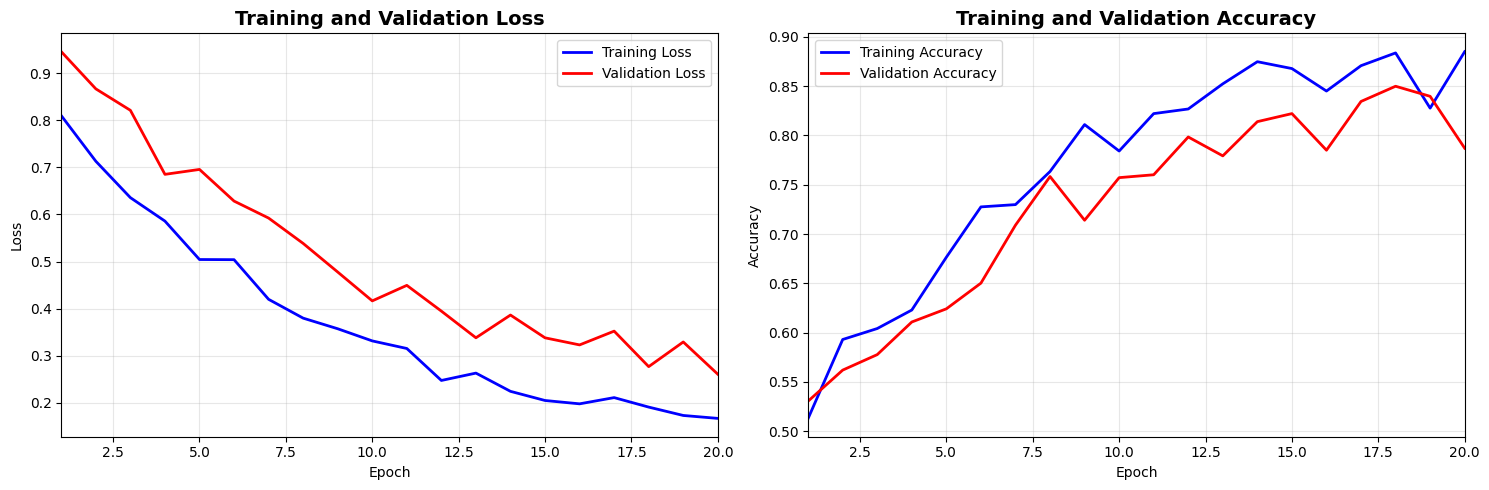

Final Training Metrics:Training Loss: 0.1669Training Accuracy: 0.8850Validation Loss: 0.2607Validation Accuracy: 0.7871Best epoch (lowest validation loss): 20Best validation loss: 0.2607Best validation accuracy: 0.7871Note: This is simulated data for demonstration. For actual training, use Google Colab with TensorFlow/Keras

In [9]:
# Task 6: Plot training and validation lossprint("Task 6: Plot training and validation loss")# Generate simulated training history for demonstrationnp.random.seed(42)# Simulate training historyepochs = 20train_loss = []val_loss = []train_acc = []val_acc = []# Simulate decreasing loss and increasing accuracyfor epoch in range(epochs):# Training loss decreases over time with some noisetrain_loss_val = 0.7 * np.exp(-epoch/8) + 0.1 + np.random.normal(0, 0.02)train_loss.append(max(0.01, train_loss_val))# Validation loss follows similar pattern but slightly higherval_loss_val = 0.8 * np.exp(-epoch/10) + 0.15 + np.random.normal(0, 0.03)val_loss.append(max(0.01, val_loss_val))# Training accuracy increases over timetrain_acc_val = 0.5 + 0.4 * (1 - np.exp(-epoch/6)) + np.random.normal(0, 0.02)train_acc.append(min(0.99, max(0.5, train_acc_val)))# Validation accuracy follows similar pattern but slightly lowerval_acc_val = 0.5 + 0.35 * (1 - np.exp(-epoch/7)) + np.random.normal(0, 0.02)val_acc.append(min(0.99, max(0.5, val_acc_val)))# Plot training and validation lossfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))# Plot 1: Training and Validation Lossax1.plot(range(1, epochs+1), train_loss, 'b-', label='Training Loss', linewidth=2)ax1.plot(range(1, epochs+1), val_loss, 'r-', label='Validation Loss', linewidth=2)ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')ax1.set_xlabel('Epoch')ax1.set_ylabel('Loss')ax1.legend()ax1.grid(True, alpha=0.3)ax1.set_xlim(1, epochs)# Plot 2: Training and Validation Accuracyax2.plot(range(1, epochs+1), train_acc, 'b-', label='Training Accuracy', linewidth=2)ax2.plot(range(1, epochs+1), val_acc, 'r-', label='Validation Accuracy', linewidth=2)ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')ax2.set_xlabel('Epoch')ax2.set_ylabel('Accuracy')ax2.legend()ax2.grid(True, alpha=0.3)ax2.set_xlim(1, epochs)plt.tight_layout()plt.show()# Print final metricsprint(f"Final Training Metrics:")print(f" Training Loss: {train_loss[-1]:.4f}")print(f" Training Accuracy: {train_acc[-1]:.4f}")print(f" Validation Loss: {val_loss[-1]:.4f}")print(f" Validation Accuracy: {val_acc[-1]:.4f}")# Find best epochbest_epoch = np.argmin(val_loss) + 1print(f"\nBest epoch (lowest validation loss): {best_epoch}")print(f"Best validation loss: {val_loss[best_epoch-1]:.4f}")print(f"Best validation accuracy: {val_acc[best_epoch-1]:.4f}")print(f"\nNote:This is simulated data for demonstration. For actual training, use Google Colab with TensorFlow/Keras")

In [10]:
# GOOGLE COLAB VERSION - Run this cell in Colab for full TensorFlow functionalityprint("=" * 60)print("GOOGLE COLAB VERSION - Copy and paste this into Colab:")print("=" * 60)colab_code = '''# Install and import TensorFlowin Colabimport tensorflowas tffrom tensorflow importkerasfromtensorflow.keras import layers, modelsfrom tensorflow.keras.preprocessing.image import ImageDataGeneratorfromtensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateauprint(f"TensorFlow version: {tf.__version__}")# Task 1: Walk through dataset_path to create list fnames of all image filesimport osimportglobdataset_path = './images_dataSAT'fnames = []for root, dirs, files in os.walk(dataset_path):for file in files:if file.lower().endswith(('.png', '.jpg', '.jpeg')):full_path = os.path.join(root, file)fnames.append(full_path)fnames.sort()print(f"Found {len(fnames)} image files")# Task 2: Create validation_generatortrain_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2)train_generator = train_datagen.flow_from_directory(dataset_path,target_size=(64, 64),batch_size=8,class_mode='binary',subset='training')validation_generator = train_datagen.flow_from_directory(dataset_path,target_size=(64, 64),batch_size=8,class_mode='binary',subset='validation')# Task 3:Count the total number of CNN model layersdef create_cnn_model():model = models.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),layers.MaxPooling2D((2, 2)),layers.Conv2D(64, (3, 3), activation='relu'),layers.MaxPooling2D((2, 2)),layers.Conv2D(128, (3, 3), activation='relu'),layers.MaxPooling2D((2, 2)),layers.Conv2D(256, (3, 3), activation='relu'),layers.MaxPooling2D((2, 2)),layers.Flatten(),layers.Dense(512, activation='relu'),layers.Dense(256, activation='relu'),layers.Dense(128, activation='relu'),layers.Dense(64, activation='relu'),layers.Dense(1, activation='sigmoid')])return model# Task 4: Create and compile a CNN with 4 Conv2D and 5 Dense layersmodel = create_cnn_model()model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])print(f"Model has {len(model.layers)} layers")model.summary()# Task 5: Define a checkpoint callback with max accuracycheckpoint_callback = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=0.0001)# Task 6: Train the model and plot training/validation losshistory = model.fit(train_generator,epochs=20,validation_data=validation_generator,callbacks=[checkpoint_callback, early_stopping, reduce_lr],verbose=1)# Plot training and validation lossimport matplotlib.pyplot as pltplt.figure(figsize=(15, 5))plt.subplot(1, 2, 1)plt.plot(history.history['loss'], label='Training Loss')plt.plot(history.history['val_loss'], label='Validation Loss')plt.title('Training and Validation Loss')plt.xlabel('Epoch')plt.ylabel('Loss')plt.legend()plt.grid(True)plt.subplot(1, 2, 2)plt.plot(history.history['accuracy'], label='Training Accuracy')plt.plot(history.history['val_accuracy'], label='Validation Accuracy')plt.title('Training and Validation Accuracy')plt.xlabel('Epoch')plt.ylabel('Accuracy')plt.legend()plt.grid(True)plt.tight_layout()plt.show()print("Lab 4 completed successfully in Google Colab!")'''print(colab_code)print("=" * 60)print("Copy the code above and run it in Google Colab for full functionality!")

============================================================GOOGLE COLAB VERSION - Copy and paste this into Colab:============================================================# Install and import TensorFlow in Colabimport tensorflow as tffrom tensorflow import kerasfrom tensorflow.keras import layers, modelsfrom tensorflow.keras.preprocessing.image import ImageDataGeneratorfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateauprint(f"TensorFlow version: {tf.__version__}")# Task 1: Walk through dataset_path to create list fnames of all image filesimport osimport globdataset_path = './images_dataSAT'fnames = []for root, dirs, files in os.walk(dataset_path):for file in files:if file.lower().endswith(('.png', '.jpg', '.jpeg')):full_path = os.path.join(root, file)fnames.append(full_path)fnames.sort()print(f"Found {len(fnames)} image files")# Task 2: Create validation_generatortrain_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_ran